# 必备设置

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from abc import ABC, abstractmethod
from tqdm import tqdm
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(False)
set_seed(42)


In [2]:
def get_fourier_coefficients(x, u):
    """
    计算给定函数在特定频率上的傅里叶系数
    """
    # 目标频率
    x=x.flatten()
    u=u.flatten()
    target_ks = [1, 5, 20]
    coeffs = []
    
    for k in target_ks:
        # 复数傅里叶系数: ∫_{-1}^1 u(x) * exp(-iπk x) dx / 2
        # 使用梯形数值积分
        integrand = u * np.exp(-1j * np.pi * k * x)
        coeff = np.trapezoid(integrand, x) / 2.0
        coeffs.append(coeff)
    return np.array(coeffs)

def solve_poisson_fd(N=2001):
    """
    返回Poisson方程的精确解: -u'' = f(x), u(-1)=u(1)=0
    精确解: u(x) = sin(πx) + sin(5πx) + sin(20πx)
    返回: x[:, None], u[:, None]
    """
    x = np.linspace(-1, 1, N)
    u = np.sin(np.pi * x) + np.sin(5 * np.pi * x) + np.sin(20 * np.pi * x)
    return x[:, None], u[:, None]
class Solver(nn.Module, ABC):
    """
    神经网络求解器的抽象类
    """
    def __init__(self, pinn=False, deep_ritz=False,num_train_points=100,batch_size=32):
        super().__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.frequency_errors={
            1: [],
            5: [],
            20: []
        }
        self.record_steps=2
        self.lb = -1.0
        self.ub = 1.0
        self.boundary_x = np.array([[-1.0], [1.0]])
        self.boundary_u = np.array([[0.0], [0.0]])
        self.N_fd = 8001
        self.num_train_points = num_train_points
        self.batch_size = batch_size
        # 生成有限差分解作为训练数据
        self.x_fd, self.u_fd = solve_poisson_fd(self.N_fd)
        indices = np.linspace(0, len(self.x_fd)-1, self.num_train_points, dtype=int)
        internal_x = self.x_fd[indices]
        internal_u = self.u_fd[indices]
        
        # 构建训练点（边界+内部）
        x_u = np.vstack([self.boundary_x, internal_x])
        u = np.vstack([self.boundary_u, internal_u])
        
        # 转换为张量
        self.lb = torch.tensor(self.lb, dtype=torch.float32).to(self.device)
        self.ub = torch.tensor(self.ub, dtype=torch.float32).to(self.device)
        self.x_u = torch.tensor(x_u, dtype=torch.float32).to(self.device)
        self.u = torch.tensor(u, dtype=torch.float32).to(self.device)
        
        # 物理信息设置
        self.pinn = pinn
        self.deep_ritz = deep_ritz
        # 生成用于计算PDE残差的点
        self.x_f = torch.linspace(self.lb, self.ub, 1000).view(-1, 1).requires_grad_(True).to(self.device)      
        
        # 优化器
        self.optimizer = None

    @abstractmethod
    def net_u(self, x):
        pass

    def net_pinn(self, x):
        """计算PDE残差: -u'' = f -> u'' + f = 0"""
        u = self.net_u(x)
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
        return u_xx + (torch.pi**2 * torch.sin(torch.pi * x) + 
                        25 * torch.pi**2 * torch.sin(5 * torch.pi * x) + 
                        400 * torch.pi**2 * torch.sin(20 * torch.pi * x))

    def net_deep_ritz(self, x):
        """计算 Deep Ritz 损失"""
        u = self.net_u(x)
        u = (1 - x**2) * u  # 强制满足边界条件
        u_x = torch.autograd.grad(u, x, 
                                  grad_outputs=torch.ones_like(u), 
                                  create_graph=True)[0]
        f_x = (torch.pi**2 * torch.sin(torch.pi * x) + 
               25 * torch.pi**2 * torch.sin(5 * torch.pi * x) + 
               400 * torch.pi**2 * torch.sin(20 * torch.pi * x))
        energy_density = 0.5 * (u_x ** 2) - f_x * u
        return torch.mean(energy_density)

    def loss(self):
        #分batch训练
        perm = torch.randperm(self.x_u.shape[0])
        x_u_batch = self.x_u[perm][:self.batch_size]
        u_batch = self.u[perm][:self.batch_size]
        # 物理驱动损失
        loss_f = torch.tensor(0.0, device=self.device)
        if self.training:
            if self.deep_ritz:
                loss_f = self.net_deep_ritz(self.x_f)
                return torch.tensor(0.0, device=self.device), loss_f
            elif self.pinn:
                f_pred = self.net_pinn(self.x_f)
                loss_f = torch.mean(f_pred ** 2)
        # 数据驱动损失        
        u_pred = self.net_u(x_u_batch)
        if self.deep_ritz:
            u_pred = (1 - x_u_batch**2) * u_pred  # 强制满足边界条件
        loss_u = torch.mean((u_batch - u_pred) ** 2)
        return loss_u, loss_f
    
    def fit(self, nIter):

        self.train()
        
        history = {'error': []}

        for i in range(1, nIter+1):
            # 计算损失 
            loss_u, loss_f = self.loss()
            if not self.pinn and not self.deep_ritz:
                # 如果不是 PINN 或 Deep Ritz，则只使用数据驱动损失
                total_loss = loss_u
                if i % 100 == 0:
                    print(f'Iter {i} | Total Loss: {total_loss.item():.3e}')
            elif self.deep_ritz:
                # Deep Ritz 只使用能量损失
                total_loss = loss_f
                if i % 100 == 0:
                    print(f'Iter {i} | Total Loss: {total_loss.item():.3e}')

            else:
                total_loss =loss_u + loss_f
                if i % 100 == 0:
                    print(f'Iter {i} | Data Loss: {loss_u.item():.3e} | Physics Loss: {loss_f.item():.3e} | Total Loss: {total_loss.item():.3e}')
            # 单步反向传播和更新
            self.optimizer.zero_grad()
            total_loss.backward()
            self.optimizer.step()            
            # 计算相对误差 
            if i % self.record_steps == 0:
                self.eval()
                with torch.no_grad():
                    x_fd_tensor = torch.tensor(self.x_fd, dtype=torch.float32).to(self.device)
                    u_pred = self.predict(x_fd_tensor)
            
                error = np.linalg.norm(u_pred - self.u_fd) / np.linalg.norm(self.u_fd)
                history['error'].append(error)
                # 计算并记录傅里叶系数误差
                coeffs_pred = get_fourier_coefficients(self.x_fd, u_pred)
                coeffs_fd = get_fourier_coefficients(self.x_fd, self.u_fd)
                for k, coeff_pred, coeff_fd in zip([1, 5, 20], coeffs_pred, coeffs_fd):
                    self.frequency_errors[k].append(np.abs(coeff_pred - coeff_fd) / np.abs(coeff_fd))
                self.train()
            
            # 定期输出误差
            if (i+1) % 100 == 0:
                print(f'Iter {i+1}/{nIter} | Relative Error: {history["error"][-1]:.3e}')
        
        self.plot(history)
        return history
        
    def predict(self, x):
        """预测结果"""
        self.eval()
        x_tensor = torch.tensor(x, dtype=torch.float32).to(self.device)
        with torch.no_grad():
            u_pred = self.net_u(x_tensor)
            if self.deep_ritz:
                u_pred=(1-x_tensor**2)*u_pred
        return u_pred.cpu().numpy() 
        
    def plot(self, history):
        """绘制预测结果和相对误差历史"""
        u_pred = self.predict(self.x_fd)
        
        # --- 结果图 ---
        title = "Poisson Equation Solution"
        if self.pinn: title += ' (Physics-Informed)'
        elif self.deep_ritz: title += ' (Deep Ritz)'
        else: title += ' (Data-Driven)'
            
        plt.figure(figsize=(12, 5))
        plt.plot(self.x_fd, self.u_fd, 'k-', label='FD Solution', linewidth=2)
        plt.plot(self.x_fd, u_pred, 'b--', label='Network Prediction', linewidth=2)
        if not self.deep_ritz:
            plt.scatter(self.x_u.detach().cpu().numpy(), 
                    self.u.detach().cpu().numpy(), 
                    color='red', s=10, zorder=5, label='Training Points')
        plt.xlabel('x')
        plt.ylabel('u(x)')
        plt.title(title)
        plt.legend()
        plt.grid(True)
        plt.show()

        plt.figure(figsize=(12, 5))
        # 使用 semilogy 因为误差通常呈指数下降
        plt.semilogy(history['error'], 'r-', label='Relative L2 Error')
        plt.xlabel('Iteration (x10)')
        plt.ylabel('Error (log scale)')
        plt.title('Relative Error History')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# 加入随机傅里叶特征

In [3]:
class MultiScaleFourierLayer(nn.Module):
    def __init__(self, input_dim, base_feature_dim, num_scales,sigma=1.0,beta=0.1):
        super().__init__()
        self.input_dim=input_dim
        self.base_feature_dim=base_feature_dim
        self.num_scales=num_scales
        base_freqs = torch.randn(self.base_feature_dim, input_dim) * np.pow(sigma,-2)
        all_freqs=[]
        for feature in base_freqs:
            for k in range(0,num_scales+1):
                scale=2.0**k
                all_freqs.append(scale*feature)
        
        omega = torch.stack(all_freqs, dim=0)
        self.register_buffer('omega',omega.reshape(-1,input_dim))
        self.total_feature_dim=self.omega.shape[0]
        print(f"Total feature dim={self.total_feature_dim}. All Fourier feature frequencies:\n{self.omega.detach().cpu().numpy().flatten()}")
        phases=torch.rand(self.total_feature_dim)*2.0*np.pi 
        self.register_buffer('phases',phases)
        self.raw_beta=nn.Parameter(torch.log(torch.tensor(beta,dtype=torch.float32)))
        self.beta=nn.functional.softplus(self.raw_beta)
    def forward(self, x):
        with torch.no_grad():
            amplitude=torch.tensor(torch.exp(- self.beta * torch.norm(self.omega,dim=1)),dtype=torch.float32)
        self.scale=torch.sqrt(torch.tensor(1.0/self.total_feature_dim,dtype=torch.float32))
        proj = torch.matmul(x, self.omega.T) + self.phases
        features = torch.cos(proj)
        features = features * self.scale * amplitude
        return features

In [4]:
class FourierFeatureSolver(Solver):
    def __init__(self,layers,base_feature_dim,num_scales,pinn=False,deep_ritz=False,num_train_points=100,batch_size=32,sigma=1.0,beta=0.1,lr=1e-3):
        super().__init__(pinn=pinn,deep_ritz=deep_ritz,num_train_points=num_train_points,batch_size=batch_size)
        self.multi_scale_fourier_layer=MultiScaleFourierLayer(input_dim=1,base_feature_dim=base_feature_dim,num_scales=num_scales,sigma=sigma,beta=beta)
        input_dim=self.multi_scale_fourier_layer.total_feature_dim
        modules = []
        linear1 = nn.Linear(input_dim, layers[0])
        nn.init.xavier_uniform_(linear1.weight, gain=nn.init.calculate_gain('tanh'))
        nn.init.zeros_(linear1.bias) 
        modules.append(linear1)
        for i in range(len(layers) - 1):
            modules.append(nn.Tanh())
            linear = nn.Linear(layers[i], layers[i+1])
            nn.init.xavier_uniform_(linear.weight, gain=nn.init.calculate_gain('tanh'))
            nn.init.zeros_(linear.bias)
            modules.append(linear)

        self.net=nn.Sequential(*modules)
        self.to(self.device)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)
    def net_u(self,x):
        x_features=self.multi_scale_fourier_layer(x)
        u=self.net(x_features)
        return u

Total feature dim=192. All Fourier feature frequencies:
[ 3.01080513e+00  6.02161026e+00  1.20432205e+01  2.40864410e+01
  4.81728821e+01  9.63457642e+01  2.32388139e+00  4.64776278e+00
  9.29552555e+00  1.85910511e+01  3.71821022e+01  7.43642044e+01
  1.40737057e+00  2.81474113e+00  5.62948227e+00  1.12589645e+01
  2.25179291e+01  4.50358582e+01 -3.28987646e+00 -6.57975292e+00
 -1.31595058e+01 -2.63190117e+01 -5.26380234e+01 -1.05276047e+02
  1.06002879e+00  2.12005758e+00  4.24011517e+00  8.48023033e+00
  1.69604607e+01  3.39209213e+01 -1.92897642e+00 -3.85795283e+00
 -7.71590567e+00 -1.54318113e+01 -3.08636227e+01 -6.17272453e+01
 -6.72929361e-02 -1.34585872e-01 -2.69171745e-01 -5.38343489e-01
 -1.07668698e+00 -2.15337396e+00 -2.50729203e+00 -5.01458406e+00
 -1.00291681e+01 -2.00583363e+01 -4.01166725e+01 -8.02333450e+01
 -1.17521143e+00 -2.35042286e+00 -4.70084572e+00 -9.40169144e+00
 -1.88033829e+01 -3.76067657e+01  2.57612967e+00  5.15225935e+00
  1.03045187e+01  2.06090374e+01  

/tmp/ipykernel_1790/598657305.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  amplitude=torch.tensor(torch.exp(- self.beta * torch.norm(self.omega,dim=1)),dtype=torch.float32)
/tmp/ipykernel_1790/1793247997.py:174: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x, dtype=torch.float32).to(self.device)


Iter 100/200 | Relative Error: 5.474e-01
Iter 100 | Total Loss: 3.971e-01
Iter 200/200 | Relative Error: 3.439e-01
Iter 200 | Total Loss: 1.754e-01


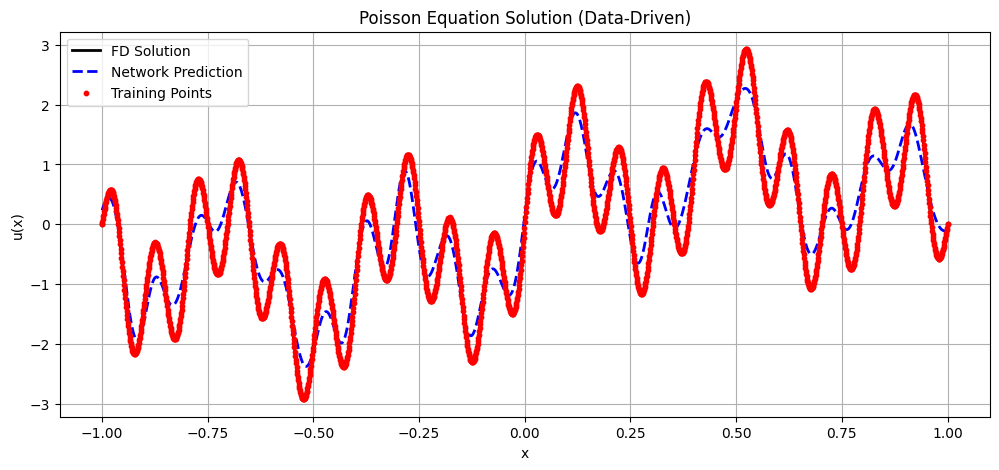

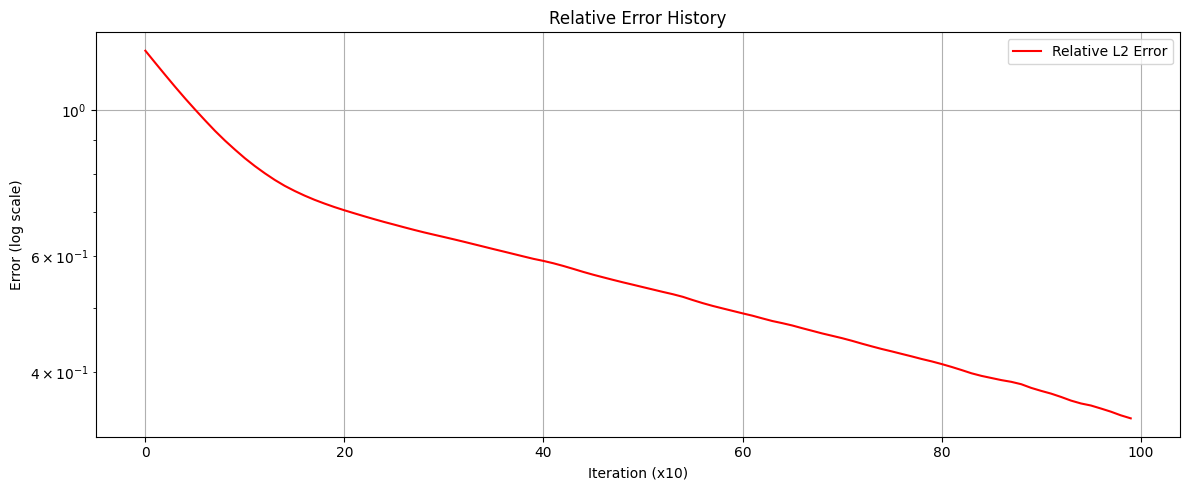

In [5]:
set_seed(42)
layers=[64,128,64,1]
base_feature_dim=32
num_scales=5
fourier_solver=FourierFeatureSolver(layers,base_feature_dim,num_scales,num_train_points=2000,batch_size=128,sigma=0.8,beta=0.01,lr=2e-4)
fourier_solver.fit(200)
regresion_data=fourier_solver.frequency_errors
regresion_matrix=np.array([regresion_data[20],regresion_data[5],regresion_data[1]])

Total feature dim=192. All Fourier feature frequencies:
[ 3.01080513e+00  6.02161026e+00  1.20432205e+01  2.40864410e+01
  4.81728821e+01  9.63457642e+01  2.32388139e+00  4.64776278e+00
  9.29552555e+00  1.85910511e+01  3.71821022e+01  7.43642044e+01
  1.40737057e+00  2.81474113e+00  5.62948227e+00  1.12589645e+01
  2.25179291e+01  4.50358582e+01 -3.28987646e+00 -6.57975292e+00
 -1.31595058e+01 -2.63190117e+01 -5.26380234e+01 -1.05276047e+02
  1.06002879e+00  2.12005758e+00  4.24011517e+00  8.48023033e+00
  1.69604607e+01  3.39209213e+01 -1.92897642e+00 -3.85795283e+00
 -7.71590567e+00 -1.54318113e+01 -3.08636227e+01 -6.17272453e+01
 -6.72929361e-02 -1.34585872e-01 -2.69171745e-01 -5.38343489e-01
 -1.07668698e+00 -2.15337396e+00 -2.50729203e+00 -5.01458406e+00
 -1.00291681e+01 -2.00583363e+01 -4.01166725e+01 -8.02333450e+01
 -1.17521143e+00 -2.35042286e+00 -4.70084572e+00 -9.40169144e+00
 -1.88033829e+01 -3.76067657e+01  2.57612967e+00  5.15225935e+00
  1.03045187e+01  2.06090374e+01  

/tmp/ipykernel_1790/598657305.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  amplitude=torch.tensor(torch.exp(- self.beta * torch.norm(self.omega,dim=1)),dtype=torch.float32)
/tmp/ipykernel_1790/1793247997.py:174: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x, dtype=torch.float32).to(self.device)


Iter 100/480 | Relative Error: 6.794e-01
Iter 100 | Total Loss: -6.989e+02
Iter 200/480 | Relative Error: 4.885e-01
Iter 200 | Total Loss: -8.770e+02
Iter 300/480 | Relative Error: 4.288e-01
Iter 300 | Total Loss: -9.364e+02
Iter 400/480 | Relative Error: 4.118e-01
Iter 400 | Total Loss: -9.804e+02


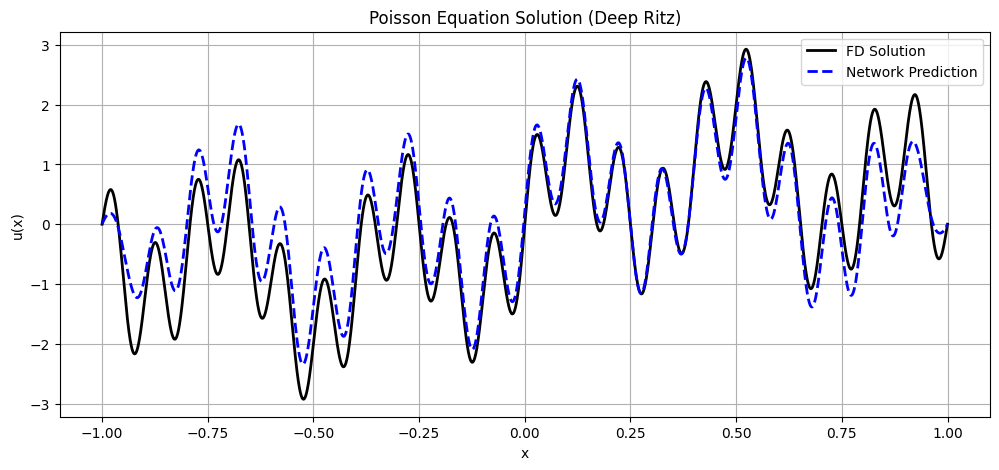

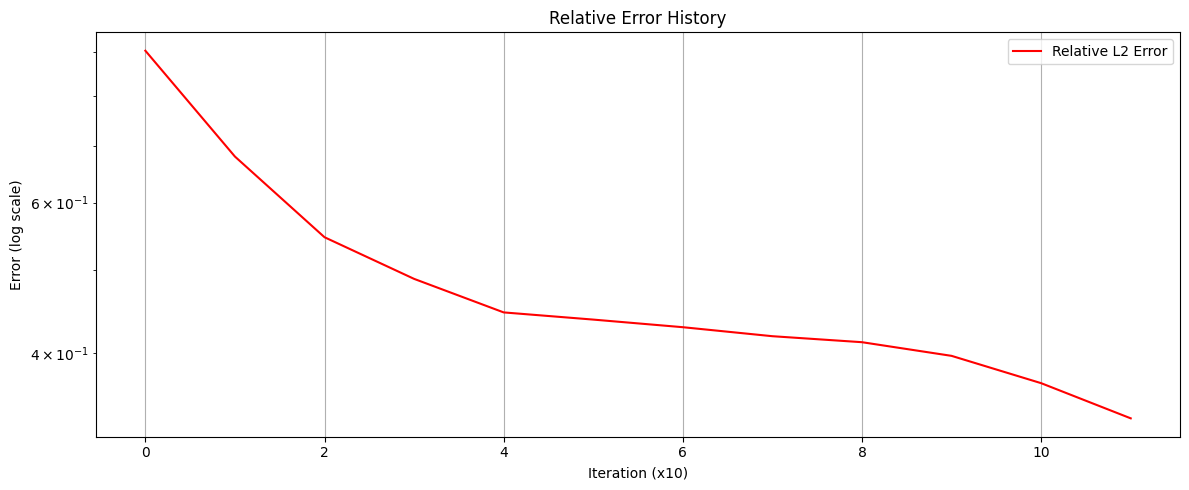

In [6]:
set_seed(42)
layers=[64,128,64,1]
base_feature_dim=32
num_scales=5
fourier_solver=FourierFeatureSolver(layers,base_feature_dim,num_scales,num_train_points=2000,batch_size=128,sigma=0.8,beta=0.01,lr=2e-4,deep_ritz=True)
fourier_solver.record_steps=40
fourier_solver.fit(480)
deep_ritz_data=fourier_solver.frequency_errors
deep_ritz_matrix=np.array([deep_ritz_data[20],deep_ritz_data[5],deep_ritz_data[1]])


In [7]:
set_seed(42)
layers=[64,128,64,1]
base_feature_dim=32
num_scales=5
fourier_solver=FourierFeatureSolver(layers,base_feature_dim,num_scales,num_train_points=2000,batch_size=128,sigma=0.8,beta=0.01,lr=2e-4,pinn=True)
fourier_solver.record_steps=20
fourier_solver.fit(4000)
pinn_data=fourier_solver.frequency_errors
pinn_matrix=np.array([pinn_data[20],pinn_data[5],pinn_data[1]])

Total feature dim=192. All Fourier feature frequencies:
[ 3.01080513e+00  6.02161026e+00  1.20432205e+01  2.40864410e+01
  4.81728821e+01  9.63457642e+01  2.32388139e+00  4.64776278e+00
  9.29552555e+00  1.85910511e+01  3.71821022e+01  7.43642044e+01
  1.40737057e+00  2.81474113e+00  5.62948227e+00  1.12589645e+01
  2.25179291e+01  4.50358582e+01 -3.28987646e+00 -6.57975292e+00
 -1.31595058e+01 -2.63190117e+01 -5.26380234e+01 -1.05276047e+02
  1.06002879e+00  2.12005758e+00  4.24011517e+00  8.48023033e+00
  1.69604607e+01  3.39209213e+01 -1.92897642e+00 -3.85795283e+00
 -7.71590567e+00 -1.54318113e+01 -3.08636227e+01 -6.17272453e+01
 -6.72929361e-02 -1.34585872e-01 -2.69171745e-01 -5.38343489e-01
 -1.07668698e+00 -2.15337396e+00 -2.50729203e+00 -5.01458406e+00
 -1.00291681e+01 -2.00583363e+01 -4.01166725e+01 -8.02333450e+01
 -1.17521143e+00 -2.35042286e+00 -4.70084572e+00 -9.40169144e+00
 -1.88033829e+01 -3.76067657e+01  2.57612967e+00  5.15225935e+00
  1.03045187e+01  2.06090374e+01  

/tmp/ipykernel_1790/598657305.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  amplitude=torch.tensor(torch.exp(- self.beta * torch.norm(self.omega,dim=1)),dtype=torch.float32)
/tmp/ipykernel_1790/1793247997.py:174: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x, dtype=torch.float32).to(self.device)


Iter 100/4000 | Relative Error: 1.150e+00
Iter 100 | Data Loss: 1.997e+00 | Physics Loss: 9.013e+05 | Total Loss: 9.013e+05


KeyboardInterrupt: 

<>:74: SyntaxWarning: invalid escape sequence '\D'
<>:74: SyntaxWarning: invalid escape sequence '\D'
C:\Users\hp\AppData\Local\Temp\ipykernel_5668\596128738.py:74: SyntaxWarning: invalid escape sequence '\D'
  cbar = fig.colorbar(sm, cax=cbar_ax, label='relative error   $   \Delta_F(k)   $  ')


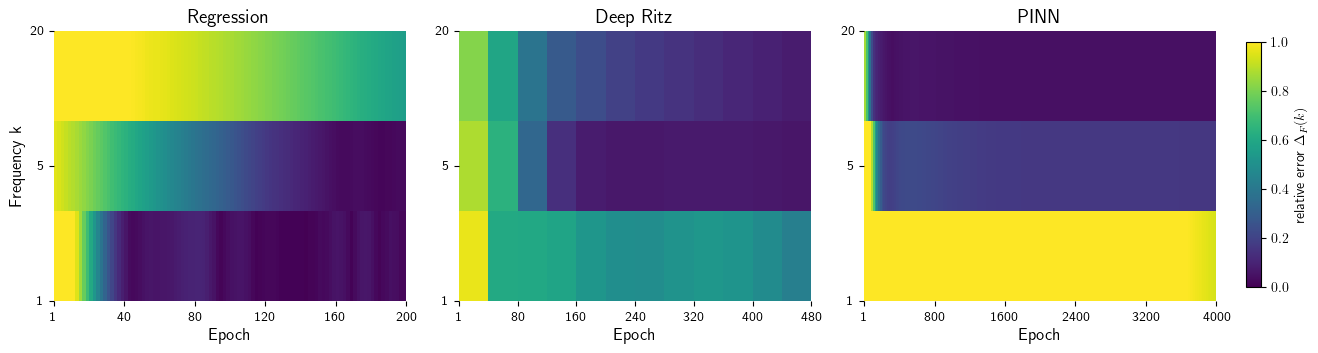

In [ ]:
import seaborn as sns
matrix_data=[regresion_matrix,deep_ritz_matrix,pinn_matrix]
plt.rcParams['text.usetex'] = True
# 1. 创建图形，包含3个子图
fig, axes = plt.subplots(1, 3, figsize=(15, 3.5))
# 调整子图间距
plt.subplots_adjust(wspace=0.15) 

# 定义三个子图的标题
titles = ['Regression', 'Deep Ritz', 'PINN']

# 循环绘制每个子图
for i, ax in enumerate(axes):

    matrix_data_i = matrix_data[i]

    # 绘制热力图
    # 注意：这里没有绘制颜色条(cbar=False)，我们将统一绘制
    heatmap = sns.heatmap(
        matrix_data_i,            # 数据矩阵
        cmap="viridis",        # 颜色映射，_r表示反转，从深蓝(低)到黄(高)
        ax=ax,                  # 指定子图
        cbar=False,             # 不在每个子图单独绘制颜色条
        linewidths=0,           # 边框宽度
        vmin=0, vmax=1          # 设置颜色范围，对应下面的颜色条0到1
    )

    # 设置标题
    ax.set_title(titles[i], fontsize=14)

    # 2. 设置坐标轴标签
    ax.set_xlabel('Epoch', fontsize=12)
    if i == 0:
        ax.set_ylabel('Frequency k', fontsize=12)


    # 3. 设置刻度 
    if i == 0:
        # Regression
        x_positions = [0, 20, 40, 60, 80, 100] # 数据矩阵中的位置
        x_labels = ['1', '40','80','120','160','200']
        y_positions = [0,  1.5, 3] 
        y_labels = ['20','5','1']  

    elif i == 1:
        # Deep Ritz
        x_positions = [0,2,4,6,8,10,12]
        x_labels = ['1', '80', '160', '240', '320', '400','480']
        y_positions = [0,  1.5, 3] 
        y_labels = ['20','5','1']  
    else:
        # PINN
        x_positions = [0,40,80,120,160,200]
        x_labels = ['1','800','1600','2400','3200','4000']
        y_positions = [0, 1.5, 3] 
        y_labels = ['20','5','1']  

    ax.set_xticks([pos  for pos in x_positions]) # +0.5是为了居中
    ax.set_xticklabels(x_labels, rotation=0)
    ax.set_yticks([pos  for pos in y_positions])
    ax.set_yticklabels(y_labels,rotation=0)


# 4. 统一添加颜色条 (Colorbar)
# 获取最后一个子图的位置，用于放置颜色条
cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7]) # [left, bottom, width, height]
from matplotlib.cm import ScalarMappable
import matplotlib.colors as colors
cmap = plt.get_cmap("viridis")
norm = colors.Normalize(vmin=0, vmax=1)
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
# 添加颜色条
cbar = fig.colorbar(sm, cax=cbar_ax, label='relative error   $   \Delta_F(k)   $  ')
cbar.set_ticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

# 5. 调整布局并显示
plt.show()

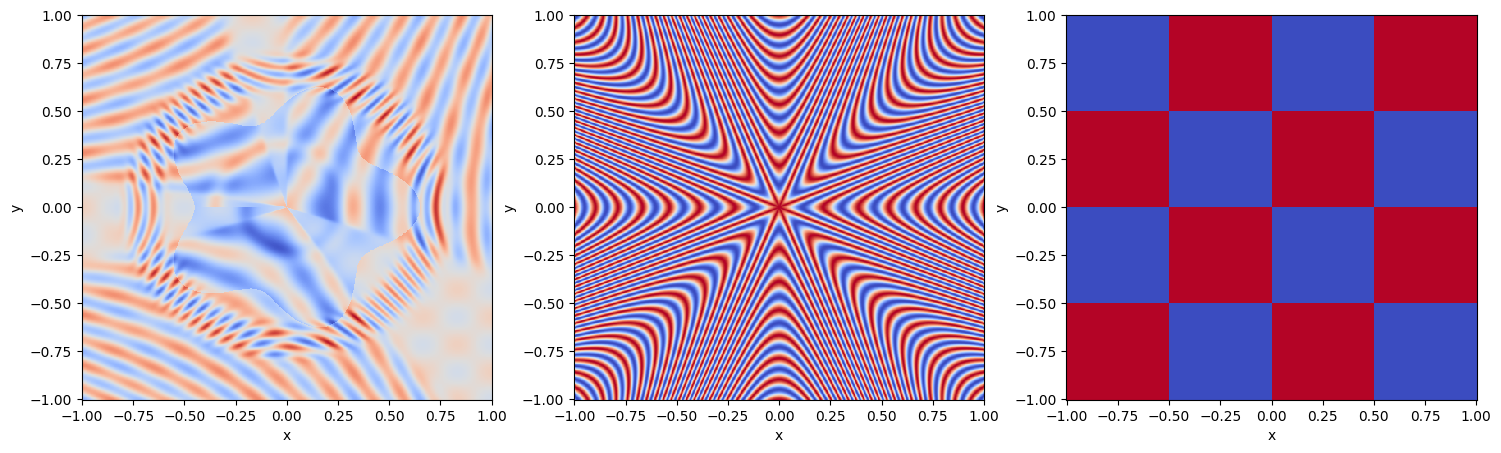

In [3]:
torch.set_default_dtype(torch.float64)
# 辅助函数定义
def sigma_k(t, k):
    """平滑逻辑门 σ_k(t) = 1/(1+e^{-kt})"""
    return 1.0 / (1.0 + torch.exp(-k * t))

def AG(theta, a0, a1, k):
    """
    角度门控函数 (Angular Gate)
    AG(θ; a0,a1,k) = σ_k((a1-a0)/2 - |atan2(sin(θ-(a0+a1)/2), cos(θ-(a0+a1)/2))|)
    """
    mid = (a0 + a1) / 2.0
    half_width = (a1 - a0) / 2.0
    # 计算角度差并包裹到 [-π, π]
    angle_diff = torch.atan2(torch.sin(theta - mid), torch.cos(theta - mid))
    return sigma_k(half_width - torch.abs(angle_diff), k)

def BP(r, r1, r2, k):
    """
    带通函数 (Bandpass)，基于两个逻辑门的差
    BP(r; r1,r2,k) = σ_k(r-r1) * [1 - σ_k(r-r2)]
    """
    return sigma_k(r - r1, k) * (1.0 - sigma_k(r - r2, k))

def f1(x, y):
    """
    f1(x1, x2) - 包含各向异性、高频环、螺旋包络、星形间断和交叉项的复杂函数
    注意：输入 x, y 应为 PyTorch 张量，定义域 [-1, 1]
    """
    # 极坐标转换
    r = torch.sqrt(x**2 + y**2)
    theta = torch.atan2(y, x)
    
    # 角门控集合 S
    S = [
        (-0.9 * torch.pi, -0.3 * torch.pi),
        (-0.1 * torch.pi, 0.5 * torch.pi),
        (0.6 * torch.pi, 0.95 * torch.pi)
    ]
    
    # rs(θ) = 0.2 + 0.15*(θ+π)/(2π)  —— 高斯螺旋包络的中心半径
    rs = 0.2 + 0.15 * (theta + torch.pi) / (2.0 * torch.pi)
    
    # r*(θ) = 0.55 + 0.10*cos(5θ)  —— 星形间断的边界
    r_star = 0.55 + 0.10 * torch.cos(5.0 * theta)
    
    # 第1项：0.35 * Σ AG(...) * cos(2π(2.2+2.5r)[x1*cos(2.5θ) + x2*sin(2.5θ)])
    term1 = 0.0
    for a0, a1 in S:
        ag = AG(theta, a0, a1, 50)
        freq = 2.0 * torch.pi * (2.2 + 2.5 * r)
        phase = x * torch.cos(2.5 * theta) + y * torch.sin(2.5 * theta)
        term1 += ag * torch.cos(freq * phase)
    term1 *= 0.35
    
    # 第2项：0.40 * BP(r; 0.62,0.78,60) * cos(2π(6+5r)[x1*cos(3θ) + x2*sin(3θ)])
    bp = BP(r, 0.62, 0.78, 60)
    freq2 = 2.0 * torch.pi * (6.0 + 5.0 * r)
    phase2 = x * torch.cos(3.0 * theta) + y * torch.sin(3.0 * theta)
    term2 = 0.40 * bp * torch.cos(freq2 * phase2)
    
    # 第3项：0.28 * exp(-(r-rs)^2/(2*0.04^2)) * cos(2π(3+3r)[x1*cos(θ+0.8) + x2*sin(θ+0.8)])
    gauss = torch.exp(-(r - rs)**2 / (2.0 * 0.04**2))
    freq3 = 2.0 * torch.pi * (3.0 + 3.0 * r)
    phase3 = x * torch.cos(theta + 0.8) + y * torch.sin(theta + 0.8)
    term3 = 0.28 * gauss * torch.cos(freq3 * phase3)
    
    # 第4项：0.12 * sign(r - r*(θ))
    term4 = 0.12 * torch.sign(r - r_star)
    
    # 第5项：0.10 * cos(6πx1) * cos(7πx2)
    term5 = 0.10 * torch.cos(6.0 * torch.pi * x) * torch.cos(7.0 * torch.pi * y)
    
    return term1 + term2 + term3 + term4 + term5

def f2(x,y):
    return torch.cos(2*torch.pi*(4+3*torch.sqrt(x**2+y**2))*(x*torch.cos(5*torch.atan2(y,x))+y*torch.sin(5*torch.atan2(y,x))))

def f3(x, y):
    """
    f3(x1, x2) = sign(sin(2π*f_x*x1) * sin(2π*f_y*x2))
    其中 f_x = f_y = 1，生成棋盘格间断模式
    """
    fx, fy = 1.0, 1.0
    return torch.sign(torch.sin(2.0 * torch.pi * fx * x) * torch.sin(2.0 * torch.pi * fy * y))


def generate_grid_data(f, n=500):
    """
    在 Omega = [-1, 1]^2 上生成 n×n 均匀网格，并计算函数 f 的值
    
    参数:
        f: 目标函数，接受两个 torch.Tensor 参数 (x, y)，返回函数值
        n: 网格分辨率（默认 500），生成 n×n 个网格点
        
    返回:
        如果 f 输出标量场:
            X: (n, n) 的网格坐标，X[i,j] = x_i
            Y: (n, n) 的网格坐标，Y[i,j] = y_j  
            Z: (n, n) 的函数值，Z = f(X, Y)
    """
    # 在 [-1, 1] 区间生成均匀分布的坐标
    with torch.no_grad():  # 关键：在此区域内不构建计算图
        x = torch.linspace(-1, 1, n)
        y = torch.linspace(-1, 1, n)
        
        # 创建二维网格 (indexing='ij' 表示矩阵坐标系，i 对应 x，j 对应 y)
        X, Y = torch.meshgrid(x, y, indexing='ij')
        
        # 计算函数值（利用 PyTorch 广播机制）
        Z = f(X, Y)

        coords = torch.stack([X.flatten(), Y.flatten()], dim=1)  # (n*n, 2)
        values = Z.flatten().unsqueeze(1)  # (n*n, 1)
    return coords, values
coords1, values1 = generate_grid_data(f1, n=500)
coords2, values2 = generate_grid_data(f2, n=500)
coords3, values3 = generate_grid_data(f3, n=500)
n=500
X1 = coords1[:, 0].reshape(n, n)
Y1 = coords1[:, 1].reshape(n, n)
Z1 = values1.reshape(n, n)
X2 = coords2[:, 0].reshape(n, n)
Y2 = coords2[:, 1].reshape(n, n)
Z2 = values2.reshape(n, n)
X3 = coords3[:, 0].reshape(n, n)
Y3 = coords3[:, 1].reshape(n, n)
Z3 = values3.reshape(n, n)
# 1*3子图
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.pcolormesh(X1.numpy(), Y1.numpy(), Z1.numpy(),cmap='coolwarm', shading='auto')
plt.xlabel('x')
plt.ylabel('y')
plt.subplot(1, 3, 2)
plt.pcolormesh(X2.numpy(), Y2.numpy(), Z2.numpy(),cmap='coolwarm', shading='auto')
plt.xlabel('x')
plt.ylabel('y')
plt.subplot(1, 3, 3)
plt.pcolormesh(X3.numpy(), Y3.numpy(), Z3.numpy(),cmap='coolwarm', shading='auto')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [4]:
class MultiScaleFourierLayer(nn.Module):
    def __init__(self, input_dim, base_feature_dim, num_scales,sigma=1.0,beta=0.1):
        super().__init__()
        self.input_dim=input_dim
        self.base_feature_dim=base_feature_dim
        self.num_scales=num_scales
        base_freqs = torch.randn(self.base_feature_dim, input_dim) * np.pow(sigma,-1)
        self.M = self.base_feature_dim * (self.num_scales + 1)
        all_freqs=[]
        for feature in base_freqs:
            for k in range(0,num_scales+1):
                scale=2.0**k
                all_freqs.append(scale*feature)
        
        omega = torch.stack(all_freqs, dim=0)
        self.register_buffer('omega',omega.reshape(-1,input_dim))
        self.total_feature_dim=self.omega.shape[0]
        print(f"Total feature dim={self.total_feature_dim}. All Fourier feature frequencies:\n{self.omega.detach().cpu().numpy().flatten()}")
        phases=torch.rand(self.total_feature_dim)*2.0*np.pi 
        self.register_buffer('phases',phases)
        self.raw_beta=nn.Parameter(torch.log(torch.exp(torch.tensor(beta))-1.0))
        self.beta=nn.functional.softplus(self.raw_beta)
    def forward(self, x):
        self.beta=nn.functional.softplus(self.raw_beta)
        amplitude=torch.exp(- self.beta * torch.norm(self.omega,dim=1))
        self.scale=torch.sqrt(torch.tensor(1.0/self.total_feature_dim))
        proj = torch.matmul(x, self.omega.T) + self.phases
        features = torch.cos(proj)
        features = features * self.scale * amplitude
        return features

In [5]:
class CrossAttentionResidualBlock(nn.Module):
    """
    L 层 Cross-Attention 残差块
    每层: Q = Q + MultiHeadCA(Q, H)  followed by  Q = Q + FFN(Q)
    """
    def __init__(self, d_q, num_layers, num_heads):
        super().__init__()
        self.d_q = d_q
        self.num_layers = num_layers
        self.num_heads = num_heads
        assert d_q % num_heads == 0, "d_q must be divisible by num_heads"
        self.head_dim = d_q // num_heads
        
        # 线性投影层（每层独立）
        self.W_Q = nn.ModuleList([nn.Linear(d_q, d_q, bias=False) for _ in range(num_layers)])
        self.W_K = nn.ModuleList([nn.Linear(d_q, d_q, bias=False) for _ in range(num_layers)])
        self.W_V = nn.ModuleList([nn.Linear(d_q, d_q, bias=False) for _ in range(num_layers)])
        self.W_O = nn.ModuleList([nn.Linear(d_q, d_q, bias=False) for _ in range(num_layers)])
        

        self.FFN = nn.ModuleList([
            nn.Sequential(nn.Linear(d_q, d_q), nn.ReLU())
            for _ in range(num_layers)
        ])
        
        self.scale = 1.0 / np.sqrt(self.head_dim)
    
    def forward(self, Q, H):
        """
        Q: (batch, d_q) - Query 初始latent
        H: (batch, N_tok, d_q) - Key/Value tokens (来自RFF reshape)
        返回: (batch, d_q)
        """
        batch_size = Q.size(0)
        
        for i in range(self.num_layers):
            # --- Multi-Head Cross Attention ---
            Q_i = self.W_Q[i](Q)  # (batch, d_q)
            K_i = self.W_K[i](H)  # (batch, N_tok, d_q)
            V_i = self.W_V[i](H)  # (batch, N_tok, d_q)
            
            # 拆分为多头的形状
            # Q: (batch, num_heads, 1, head_dim)
            Q_m = Q_i.view(batch_size, self.num_heads, self.head_dim).unsqueeze(2)
            # K, V: (batch, num_heads, N_tok, head_dim)
            K_m = K_i.view(batch_size, -1, self.num_heads, self.head_dim).permute(0, 2, 3, 1)
            V_m = V_i.view(batch_size, -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
            
            # 注意力分数: (batch, num_heads, 1, N_tok)
            scores = torch.matmul(Q_m, K_m) * self.scale
            attn = torch.softmax(scores, dim=-1)
            
            # 聚合: (batch, num_heads, 1, head_dim) -> (batch, d_q)
            out = torch.matmul(attn, V_m).squeeze(2).reshape(batch_size, self.d_q)
            out = self.W_O[i](out)
            
            # 残差连接 1
            Q = Q + out
            
            # --- FFN + 残差 ---
            Q = Q + self.FFN[i](Q)
        
        return Q


In [6]:
class TwoVarFuncSolver(nn.Module, ABC):
    """
    抽象基类，处理数据生成、训练循环、学习率调度与记录
    """
    def __init__(self, f, num_train_points=20000, batch_size=4000, 
                 lr=2e-3, epochs=1000, step_size=100, gamma=0.5,**kwargs):
        super().__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.f = f
        self.num_train_points = num_train_points
        self.batch_size = batch_size
        self.lr = lr
        self.epochs = epochs
        self.step_size = step_size  # s in paper
        self.gamma = gamma          # γ in paper
        
        # 生成全网格数据 (测试集)
        # 假设 generate_grid_data 返回 (XY_coords, Z_values)
        # XY: (250000, 2), Z: (250000, 1)
        XY, Z = generate_grid_data(f, n=500)
        self.XY_all = XY.to(self.device)
        self.Z_all = Z.to(self.device)
        
        self.history = {'epoch': [], 'loss': [], 'error': []}
        self.optimizer = None
        self.mse=nn.MSELoss()
    @abstractmethod
    def net_u(self, XY):
        """前向传播，必须由子类实现"""
        pass
    
    def compute_loss(self, XY_batch, Z_batch):
        Z_pred = self.net_u(XY_batch)
        return self.mse(Z_pred, Z_batch)
    
    def fit(self, save_epochs=None):
        """
        训练循环，带StepLR调度（stepwise schedule）
        save_epochs: list，如[50, 150, 500]，保存这些epoch的预测用于可视化
        """
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        # Stepwise LR: η_e = η_0 * γ^{floor(e/s)}
        scheduler = torch.optim.lr_scheduler.StepLR(
            self.optimizer, step_size=self.step_size, gamma=self.gamma
        )
        
        saved_predictions = {} if save_epochs else None
        pbar = tqdm(range(1, self.epochs + 1))
        for epoch in pbar:
            self.train()
            perm = torch.randperm(self.num_train_points)
            
            epoch_loss = 0.0      # 累积MSE loss
            epoch_error = 0.0     # 累积Relative L2 error
            num_batches = self.num_train_points // self.batch_size
            
            for b in range(num_batches):
                batch_idx = perm[b*self.batch_size:(b+1)*self.batch_size]
                XY_batch = self.XY_all[batch_idx]
                Z_batch = self.Z_all[batch_idx]
                
                # 前向传播（训练模式，用于计算loss和error）
                Z_pred = self.net_u(XY_batch)
                
                # 计算Loss
                loss = self.mse(Z_pred, Z_batch)
                
                # 计算该batch的Relative L2 Error（无需额外eval）
                with torch.no_grad():  # 仅在此局部阻断梯度，error本身不需要梯度
                    batch_error = (torch.norm(Z_pred - Z_batch) / 
                                torch.norm(Z_batch)).item()
                
                # 反向传播与优化
                self.optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.parameters(), 1.0)
                self.optimizer.step()
                
                # 累积指标（使用.item()避免保留计算图）
                epoch_loss += loss.item()
                epoch_error += batch_error
            
            scheduler.step()
            
            # 计算epoch平均（基于训练时见过的batch数据）
            avg_loss = epoch_loss / num_batches
            avg_error = epoch_error / num_batches
            
            # 记录历史（每个epoch都记录）
            self.history['epoch'].append(epoch)
            self.history['loss'].append(avg_loss)
            self.history['error'].append(avg_error)
            
            pbar.set_postfix({
                'Loss': f"{avg_loss:.2e}", 
                'Error': f"{avg_error:.2e}",
                'LR': f"{scheduler.get_last_lr()[0]:.2e}"
            })
            
            # 如需保存特定epoch的预测，需重新计算（因之前未保存）
            if save_epochs and epoch in save_epochs and self.num_train_points == self.XY_all.shape[0]:
                self.eval()
                with torch.no_grad():
                    Z_pred_all = self.net_u(self.XY_all[:self.num_train_points])
                    saved_predictions[epoch] =  self.Z_all.cpu().numpy().copy() -Z_pred_all.cpu().numpy().copy()
        
        return self.history, saved_predictions

In [7]:
class RFF_NN_Solver(TwoVarFuncSolver):
    """
    RFF-NN: φ(x) -> FFN -> output
    与RFF-CA共享相同的RFF tokenizer和模型容量（d_q等）
    """
    def __init__(self, f, input_dim=2, base_feature_dim=128, num_scales=3,
                 d_q=64, num_layers=4, sigma=1.0, beta_init=0.1, **kwargs):
        super().__init__(f, **kwargs)
        
        self.rff = MultiScaleFourierLayer(input_dim, base_feature_dim, num_scales, sigma, beta_init)
        M = self.rff.M
        
        # FFN: 与CA版本相同的容量（L层 d_q->d_q）
        layers = []
        layers.append(nn.Linear(M, d_q))
        layers.append(nn.ReLU())
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(d_q, d_q))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(d_q, 1))
        
        self.net = nn.Sequential(*layers)
        self.to(self.device)
    
    def net_u(self, XY):
        phi = self.rff(XY)
        return self.net(phi)


class RFF_CA_Solver(TwoVarFuncSolver):
    """
    RFF-CA: φ(x) -> Initial Q -> CA Blocks -> Output
    Q^(0) 来自 φ(x) 的线性投影，H(x) 来自 φ(x) 的 reshape
    """
    def __init__(self, f, input_dim=2, base_feature_dim=128, num_scales=3,
                 d_q=64, num_layers=4, num_heads=4, sigma=1.0, beta_init=0.1, **kwargs):
        super().__init__(f, **kwargs)
        
        self.rff = MultiScaleFourierLayer(input_dim, base_feature_dim, num_scales, sigma, beta_init)
        M = self.rff.M
        self.d_q = d_q
        
        # 确保 M 可被 d_q 整除，以便 reshape 为 tokens
        # 论文中 N_tok = M / d_q，每个token宽度为d_q
        assert M % d_q == 0, f"M={M} must be divisible by d_q={d_q}"
        self.N_tok = M // d_q
        
        # 初始投影：从 φ(x) (M维) 到 Q^(0) (d_q维)
        self.initial_fc = nn.Sequential(
            nn.Linear(M, d_q),
            nn.ReLU()
        )
        
        # Cross Attention Residual Blocks
        self.ca_blocks = CrossAttentionResidualBlock(d_q, num_layers, num_heads)
        
        # 输出层
        self.output_layer = nn.Linear(d_q, 1)
        self.to(self.device)
    
    def net_u(self, XY):
        phi = self.rff(XY)  # (batch, M)
        
        # 生成 H(x): reshape φ(x) 为 tokens
        batch_size = phi.shape[0]
        H = phi.view(batch_size, self.N_tok, self.d_q)  # (batch, N_tok, d_q)
        
        # 生成初始 Q^(0)
        Q = self.initial_fc(phi)  # (batch, d_q)
        
        # Cross Attention
        Q_L = self.ca_blocks(Q, H)  # (batch, d_q)
        
        # 输出
        return self.output_layer(Q_L)


# ---  NN-CA (x作为Query，RFF作为KV) ---
class NN_CA_Solver(TwoVarFuncSolver):
    """
    NN-CA: x -> Initial Q；φ(x) -> H(x)
    与RFF-CA相同的全局维度设置（d_q, num_layers等）
    """
    def __init__(self, f, input_dim=2, base_feature_dim=128, num_scales=3,
                 d_q=64, num_layers=4, num_heads=4, sigma=1.0, beta_init=0.1, **kwargs):
        super().__init__(f, **kwargs)
        
        # 仍然使用RFF生成H(x)，但不用于初始化Q
        self.rff = MultiScaleFourierLayer(input_dim, base_feature_dim, num_scales, sigma, beta_init)
        M = self.rff.M
        self.d_q = d_q
        assert M % d_q == 0
        self.N_tok = M // d_q
        
        # 初始 Q^(0) 来自原始输入 x，而非φ(x)
        self.initial_fc = nn.Sequential(
            nn.Linear(input_dim, d_q),
            nn.ReLU()
        )
        
        # 共享相同的CA架构
        self.ca_blocks = CrossAttentionResidualBlock(d_q, num_layers, num_heads)
        self.output_layer = nn.Linear(d_q, 1)
        self.to(self.device)
    
    def net_u(self, XY):
        # 生成 H(x) 从 RFF
        phi = self.rff(XY)
        batch_size = phi.shape[0]
        H = phi.view(batch_size, self.N_tok, self.d_q)
        
        # 初始 Q 来自 x
        Q = self.initial_fc(XY)  # (batch, d_q)
        
        # Cross Attention
        Q_L = self.ca_blocks(Q, H)
        
        return self.output_layer(Q_L)


In [8]:
def plot_training_curves(results_dict, save_path=None):
    """
    绘制与论文图6类似的6子图对比（3个函数 × 2种指标）
    results_dict: {'f1': {'RFF-NN': history, 'RFF-CA': history, ...}, ...}
    """
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    funcs = ['f1', 'f2', 'f3']
    colors = {'RFF-NN': '#1f77b4', 'RFF-CA': '#ff7f0e', 'NN-CA': '#2ca02c'}
    
    for idx, func in enumerate(funcs):
        # 第0行: Training Loss
        ax = axes[0, idx]
        for name in ['RFF-NN', 'RFF-CA']:
            if name in results_dict[func]:
                h = results_dict[func][name]
                ax.semilogy(h['epoch'], h['loss'], label=name, color=colors[name], linewidth=1.5)
        ax.set_title(f'{func.upper()} Train Loss', fontsize=12)
        ax.grid(True, which="both", ls="-", alpha=0.2)
        if idx == 0:
            ax.legend()
        
        # 第1行: Relative L2 Error
        ax = axes[1, idx]
        for name in ['RFF-NN', 'RFF-CA', 'NN-CA']:
            if name in results_dict[func]:
                h = results_dict[func][name]
                ax.semilogy(h['epoch'], h['error'], label=name, color=colors[name], linewidth=1.5)
        ax.set_title(f'{func.upper()} Rel. $L^2$ Error', fontsize=12)
        ax.set_xlabel('Epoch')
        ax.grid(True, which="both", ls="-", alpha=0.2)
        if idx == 0:
            ax.legend()
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
set_seed(42)
config = {
    'input_dim': 2,
    'base_feature_dim': 128,  # m_base
    'num_scales': 3,          # K
    'd_q': 64,                # model width
    'num_layers': 4,          # L
    'num_heads': 4,           # n_heads
    'sigma': 0.1,
    'beta_init': 0.1,
    'num_train_points': 250000,
    'batch_size': 5000,
    'lr': 2e-3,
}

# 训练配置
train_config_f1_f2 = {'epochs': 500, 'step_size': 100, 'gamma': 0.5}
train_config_f3 = {'epochs': 500, 'step_size': 50, 'gamma': 0.5}
results = {'f1': {}, 'f2': {}, 'f3': {}}
XY,Z= generate_grid_data(f1, n=500)
X=XY[:,0].reshape(500,500).numpy()
Y=XY[:,1].reshape(500,500).numpy()


Total feature dim=512. All Fourier feature frequencies:
[  2.99556288   2.42377791   5.99112576 ...  55.27254056 124.38196319
 110.54508111]


  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [27:27<00:00,  3.30s/it, Loss=2.90e-07, Error=5.36e-04, LR=1.95e-06]


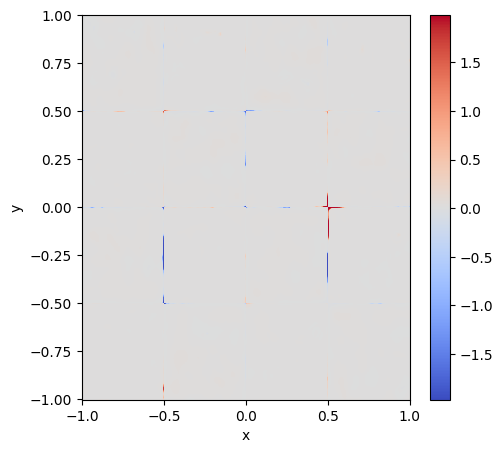

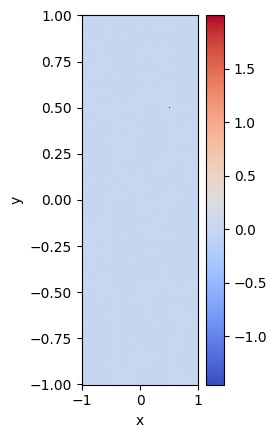

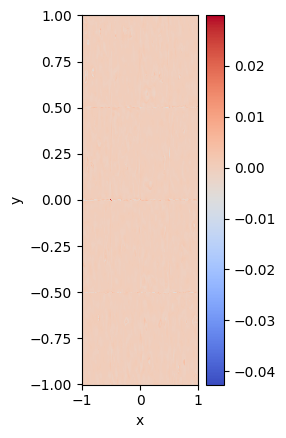

Total feature dim=512. All Fourier feature frequencies:
[ -8.65915291  10.45844494 -17.31830582 ...  -0.77812588  94.93234874
  -1.55625175]


 16%|█▌        | 78/500 [00:36<03:16,  2.14it/s, Loss=6.11e-04, Error=2.13e-02, LR=1.00e-03]


KeyboardInterrupt: 

In [ ]:
for name, SolverClass in [('RFF-CA', RFF_CA_Solver)]:
    solver = SolverClass(f3, **config, **train_config_f3)
    history,f3_predictions = solver.fit(save_epochs=[50, 150, 500])
    results['f3'][name] = history
    plot_error_heatmaps(f3_predictions)

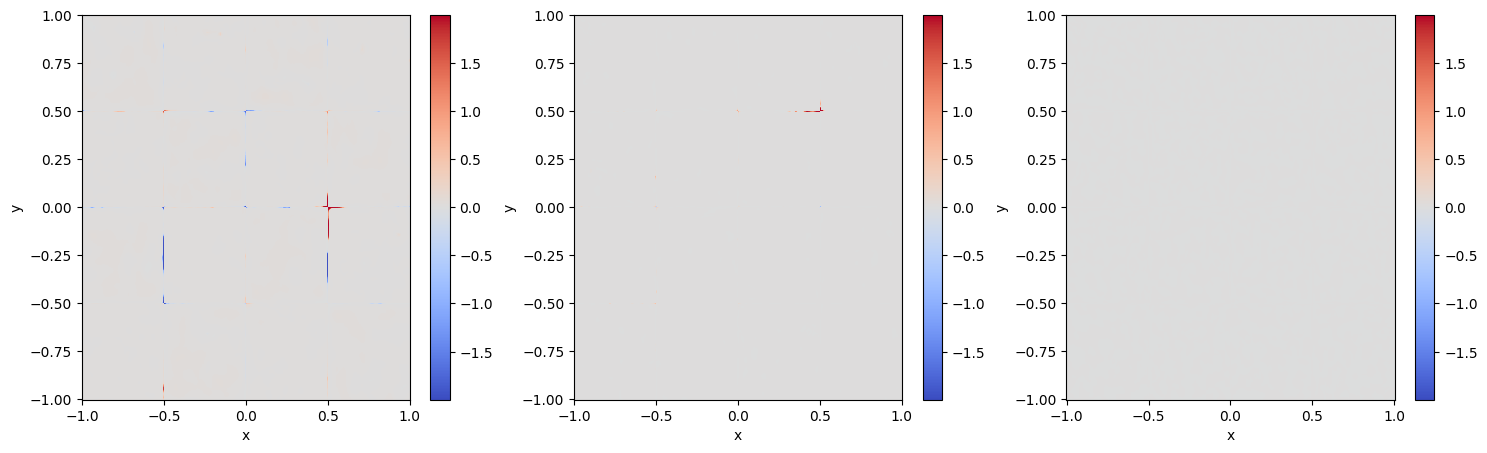

In [18]:
from matplotlib.colors import TwoSlopeNorm
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm # 使用这个代替 DivergingNorm

def plot_error_heatmaps(predictions_dict):
    plt.figure(figsize=(18, 5))

    # 1. 找出所有数据中的最大绝对值，用于设置对称的颜色条范围
    max_val = 0
    for epoch in [50, 150, 500]:
        data = predictions_dict[epoch].reshape(500, 500)
        max_val = max(max_val, abs(data).max())

    # 2. 创建归一化对象，指定 0 为中间值（center）
    norm = TwoSlopeNorm(vcenter=0, vmin=-max_val, vmax=max_val)

    for i, epoch in enumerate([50, 150, 500]):
        plt.subplot(1, 3, i + 1)
        # 3. 在 pcolormesh 中传入 norm 参数
        im = plt.pcolormesh(X, Y, predictions_dict[epoch].reshape(500, 500),
                            cmap='coolwarm', shading='auto', norm=norm)

        plt.colorbar(im)
        plt.xlabel('x')
        plt.ylabel('y')

    plt.show()
plot_error_heatmaps(f3_predictions)

Total feature dim=512. All Fourier feature frequencies:
[   2.84352907    7.34459915    5.68705813 ...  -12.47591222 -180.78120402
  -24.95182445]


100%|██████████| 500/500 [03:49<00:00,  2.18it/s, Loss=4.36e-07, Error=5.75e-04, LR=1.95e-06]


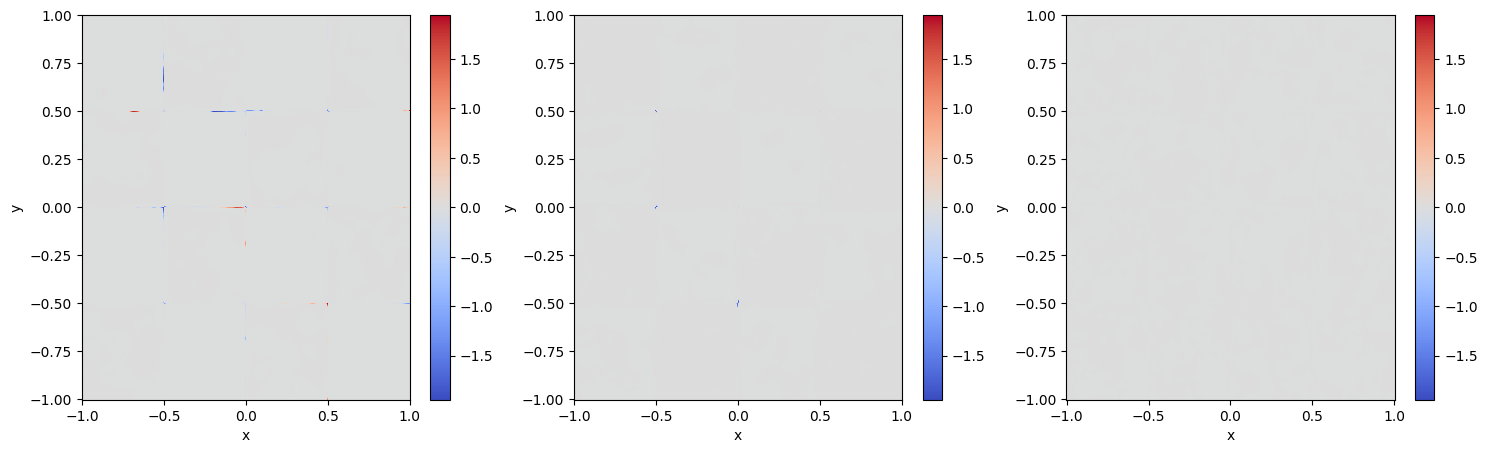

In [19]:
for name, SolverClass in [('RFF-NN', RFF_NN_Solver)]:
    solver = SolverClass(f3, **config, **train_config_f3)
    history,f3_predictions = solver.fit(save_epochs=[50, 150, 500])
    results['f3'][name] = history
    plot_error_heatmaps(f3_predictions)

Total feature dim=512. All Fourier feature frequencies:
[  9.46275294   8.5404992   18.92550588 ... -25.64883815 -91.57296535
 -51.2976763 ]


100%|██████████| 500/500 [25:33<00:00,  3.07s/it, Loss=8.62e-05, Error=8.67e-03, LR=1.95e-06]


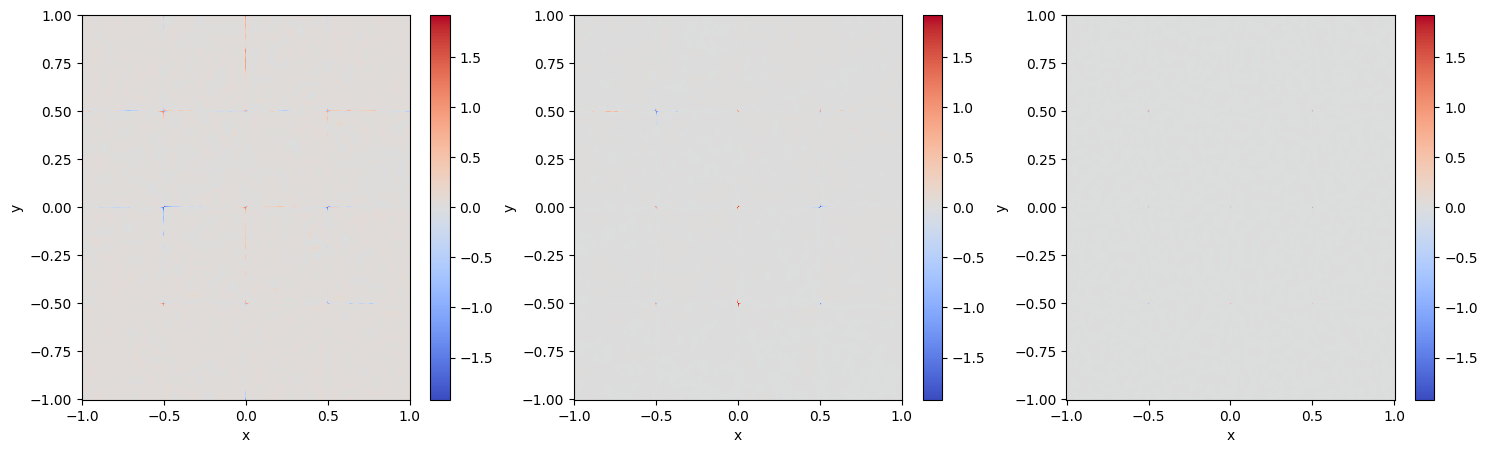

In [23]:
for name, SolverClass in [('NN-CA', NN_CA_Solver)]:
    solver = SolverClass(f3, **config, **train_config_f3)
    history,f3_predictions = solver.fit(save_epochs=[50, 150, 500])
    results['f3'][name] = history


In [35]:
import dill
dill.dump_session('session.pkl')


In [ ]:
for name, SolverClass in [('NN-CA', NN_CA_Solver)]:
    solver = SolverClass(f2, **config, **train_config_f1_f2)
    history,f2_predictions = solver.fit(save_epochs=[50, 150, 500])
    results['f2'][name] = history
    plot_error_heatmaps(f2_predictions)

/tmp/ipykernel_1757/2801337666.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/tmp/ipykernel_1757/2801337666.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


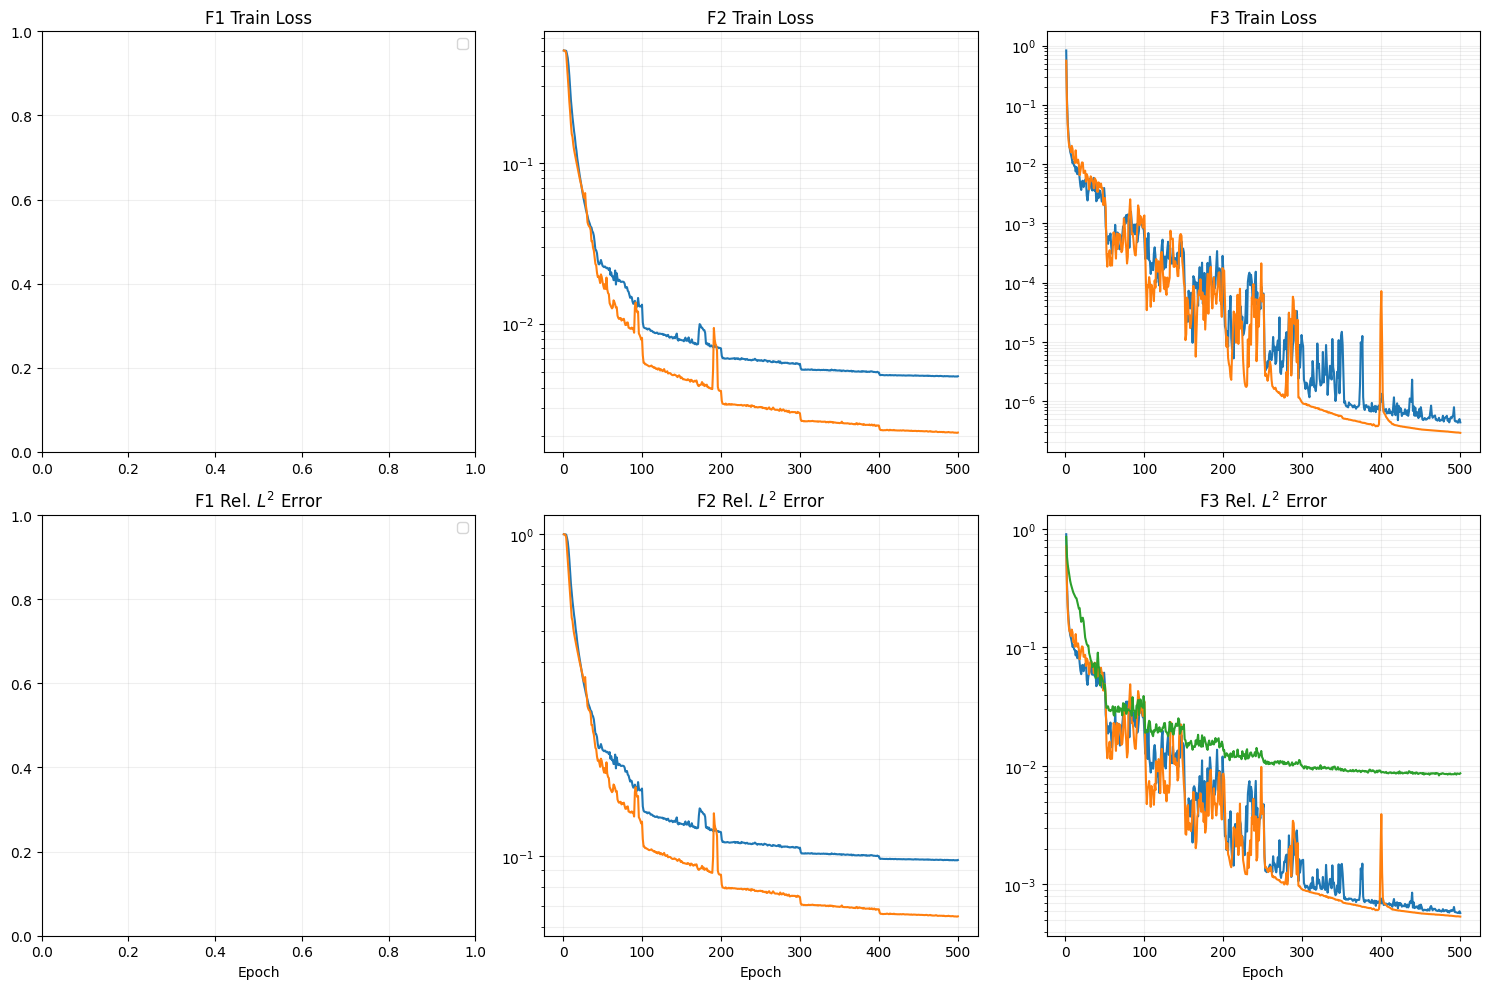

In [32]:
plot_training_curves(results)

Training on f2...
Total feature dim=512. All Fourier feature frequencies:
[ -1.75501203   2.77243822  -3.51002406 ... -14.99276705 -44.95326348
 -29.9855341 ]


  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [03:48<00:00,  2.19it/s, Loss=4.70e-03, Error=9.70e-02, LR=6.25e-05]


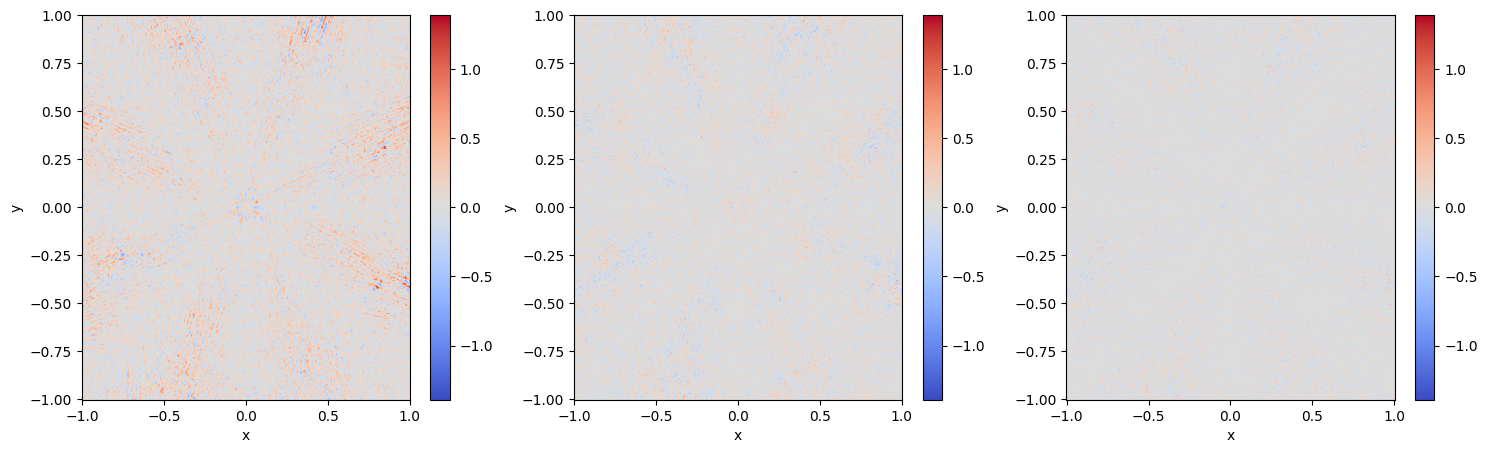

Total feature dim=512. All Fourier feature frequencies:
[  -6.07343594   25.94505491  -12.14687188 ...  -46.95557966 -127.81595902
  -93.91115932]


100%|██████████| 500/500 [27:31<00:00,  3.30s/it, Loss=2.10e-03, Error=6.48e-02, LR=6.25e-05]


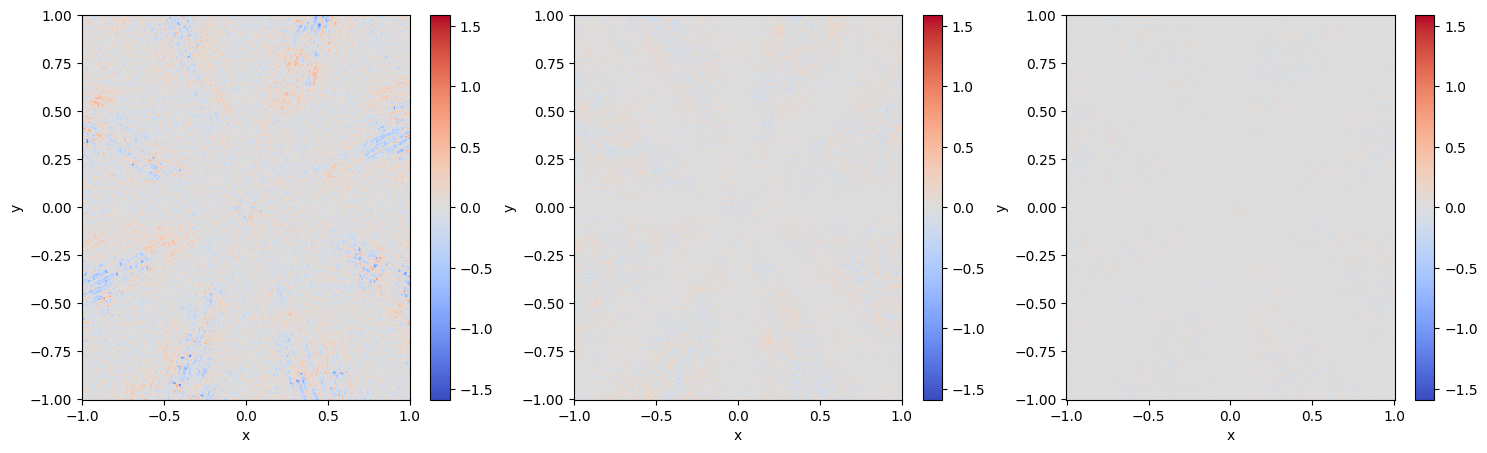

In [21]:
# 训练 f2
print("Training on f2...")
for name, SolverClass in [('RFF-NN', RFF_NN_Solver),('RFF-CA', RFF_CA_Solver)]:
    solver = SolverClass(f2, **config, **train_config_f1_f2)
    history,f2_predictions = solver.fit(save_epochs=[50, 150, 500])
    results['f2'][name] = history
    plot_error_heatmaps(f2_predictions)

In [ ]:
plot_training_curves(results)